# Metrics

Implement metrics to evaluate clustering performance based on BCubed.

$$
P_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|C(i)|} \sum_{j \in C(i)}B(i, j)
\\
R_b = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{|L(i)|} \sum_{j \in 
L(i)}B(i, j)
$$

Where $C(i)$ is the cluster (trackster) that contains layercluster $i$, and $L(i)$ are all layerclusters of the same subject (simtrackster) as layercluster $i$.

$B(i,j)$ is:
- 1 (a fraction as layerclusters can be shared by different tracksters)
    - if a pair of layerclusters $(i, j)$ of the same subject (simtrackster) are in the same cluster (trackster)
- 0 otherwise

Question: how to handle fractional assignments?

Then the F-score is computed as:
$$
F_p = \frac{2P_bR_b}{P_b + R_b}
$$

In [221]:
import uproot
import awkward as ak
import numpy as np
from utils.plotting_utils import plot_event

file_name = "~/data/photon/new_ntuples_13872546_165.root"
# file_name = "~/data/multiparticle/new_ntuples_14132277_842.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [222]:
# check that the vertex indices are in the same ball-park
print(max(ak.flatten(tracksters["vertices_indexes"].array()[1])))
print(max(ak.flatten(simtracksters["stsSC_vertices_indexes"].array()[1])))
print(tracksters["NClusters"].array()[1])

368
376
377


In [223]:
def get_map(tree, eid):
    i2o = {}
    for st_idx, st in enumerate(tree.array()[eid]):
        for i in st:
            if i in i2o:
                i2o[i].append(st_idx)
            else:
                i2o[i] = [st_idx]
    return i2o

In [224]:
def B(i, j, mapping):
    # assumes i and j are in the same trackster/simtrackster
    mi = mapping[i]
    mj = mapping[j]
    match = np.intersect1d(mi, mj)
    f_i = len(match) / len(mi)
    f_j = len(match) / len(mj)
    return (f_i + f_j) / 2

def bcubed_precision(tracksters, i2rt, i2st, eid):
    P_b = 0
    all_vertices = ak.flatten(tracksters["vertices_indexes"].array()[eid])
    t_vertices = tracksters["vertices_indexes"].array()[eid]

    for i in all_vertices:
        i_score = 0

        # get all tracksters i is in
        i_tracksters = i2rt[i]
        i_multiplier = 1 / len(i_tracksters) # XXX: to be multiplied by the real fractions
        
        # get score for each trackster
        for i_trackster in i_tracksters:
            i_trackster_score = 0
            C = t_vertices[i_trackster]
            for j in C:
                i_trackster_score += B(i, j, i2st)
            i_trackster_score /= len(C)
            i_score += i_trackster_score * i_multiplier

        # add to the outer P_b sum
        P_b += i_score

    # normalize the result
    return P_b / len(all_vertices)

def bcubed_recall(simtracksters, i2rt, i2st, eid):
    P_r = 0
    
    # XXX: only no-noise datapoints
    all_vertices = ak.flatten(tracksters["vertices_indexes"].array()[eid])
    st_vertices = simtracksters["stsSC_vertices_indexes"].array()[eid]

    for i in all_vertices:
        i_score = 0

        # get all simtracksters i is in
        i_tracksters = i2st[i]
        i_multiplier = 1 / len(i_tracksters) # XXX: to be multiplied by the real fractions
        
        # get score for each trackster
        for i_trackster in i_tracksters:
            i_trackster_score = 0

            # XXX: only no-noise datapoints
            L = np.intersect1d(st_vertices[i_trackster], all_vertices)
            for j in L:
                i_trackster_score += B(i, j, i2rt)
            i_trackster_score /= len(L)
            i_score += i_trackster_score * i_multiplier

        # add to the outer P_r sum
        P_r += i_score

    # normalize the result
    return P_r / len(all_vertices)

def f_score(A, B):
    return (2 * A * B) / (A + B)

Precision: 0.83, Recall: 0.32, F-score: 0.46


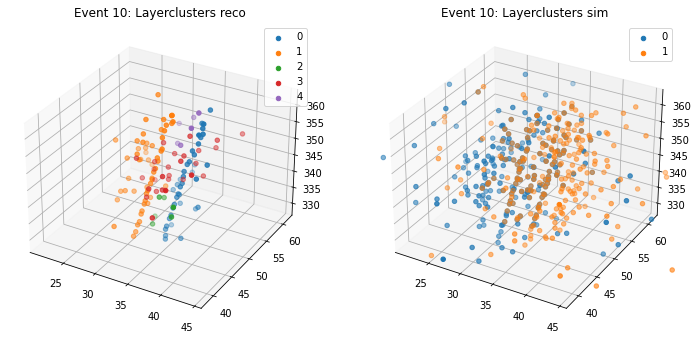

In [226]:
eid = 10
i2rt = get_map(tracksters["vertices_indexes"], eid)
i2st = get_map(simtracksters["stsSC_vertices_indexes"], eid)
precision = bcubed_precision(tracksters, i2rt, i2st, eid)
recall = bcubed_recall(simtracksters, i2rt, i2st, eid)

print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {f_score(precision, recall):.2f}")
plot_event(tracksters, simtracksters, eid, legend=True)